<a href="https://colab.research.google.com/github/carlibeisel/mason_water_budget/blob/main/tvgwfm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created: October 25, 2024

Purpose: view TV groundwater data from Modflow6 and crop to Mason Drainage

Output units from the TVGWFM are in cubic feet per day

## Process groundwater data from TVGWFM and convert to csv

In [1]:
!pip install flopy
import flopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import box
from shapely.geometry import box, Polygon
import matplotlib.gridspec as gridspec
import calendar

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.6 MB/s eta 0:00:00
Mounted at /content/drive


In [35]:
# Load the dataset (obtained from executing modflow) and access the data

model_dir = '/content/drive/MyDrive/Data/Mason Water Budget/data_input/groundwater/model'

# load the model
sim = flopy.mf6.MFSimulation.load(
    sim_ws=model_dir,
    verbosity_level=0,
)

ml = sim.get_model("mf6-tv_hist")

bud = ml.output.budget()
bud_array_list = bud.get_data(idx=0, full3D=True)

bud.get_unique_record_names()

[np.bytes_(b'          STO-SS'),
 np.bytes_(b'    FLOW-JA-FACE'),
 np.bytes_(b'      DATA-SPDIS'),
 np.bytes_(b'             WEL'),
 np.bytes_(b'             DRN'),
 np.bytes_(b'             RIV'),
 np.bytes_(b'             GHB')]

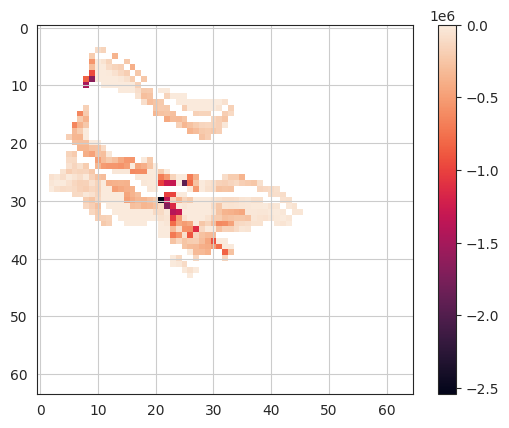

In [36]:
# View the raw data

# get a list of numpy masked arrays, where each stress period (and time-step)
# is an item in the list
drn_out_arr = bud.get_data(text='DRN', full3D=True)
# get a single masked array out of the list (in this case the 0th stress period)
drn_ma_i = drn_out_arr[0]
# get a regular numpy array by filling the masked cells with nan
drn_arr_i = drn_ma_i.filled(np.nan)
# get the top layer values
drn_arr_lay1 = drn_arr_i[0, :, :]
# plot
plt.imshow(drn_arr_lay1)
plt.colorbar()
plt.grid()

In [23]:
drn_arr_i.shape

(6, 64, 65)

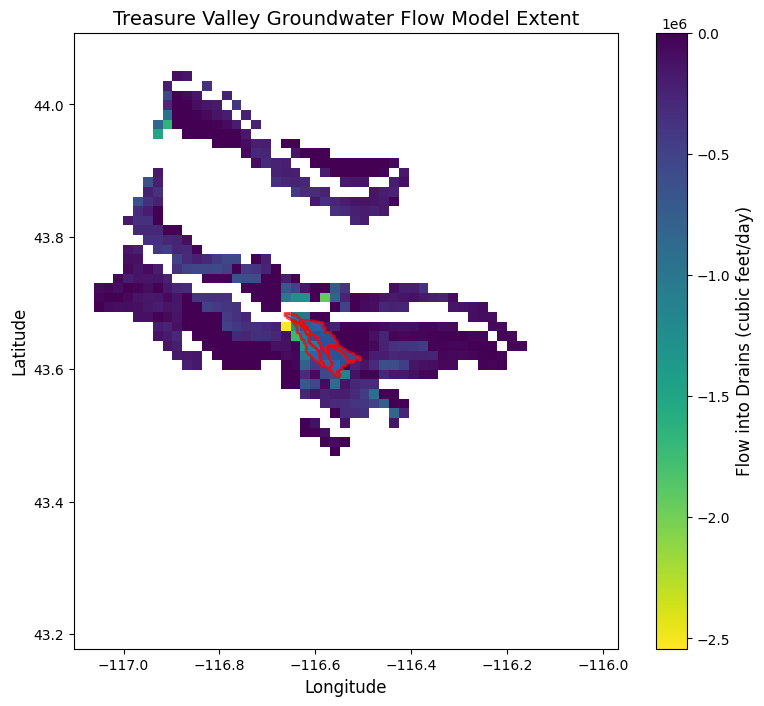

In [24]:

reach_gdf = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp')
min_lon, min_lat, max_lon, max_lat = -117.103530233726, 43.1778883119514, -115.768691366538, 44.1083
extent = [min_lon, max_lon, min_lat, max_lat]
right_crop_factor = 0.15
adjusted_max_lon = max_lon - (max_lon - min_lon) * right_crop_factor
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(drn_arr_lay1, cmap='viridis_r', extent=extent, origin='upper')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Flow into Drains (cubic feet/day)', fontsize=12)
reach_gdf.plot(ax=ax, edgecolor='red', linewidth=2, alpha=0.7)
ax.set_xlim(min_lon, adjusted_max_lon)
ax.set_ylim(min_lat, max_lat)
plt.title('Treasure Valley Groundwater Flow Model Extent', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.show()

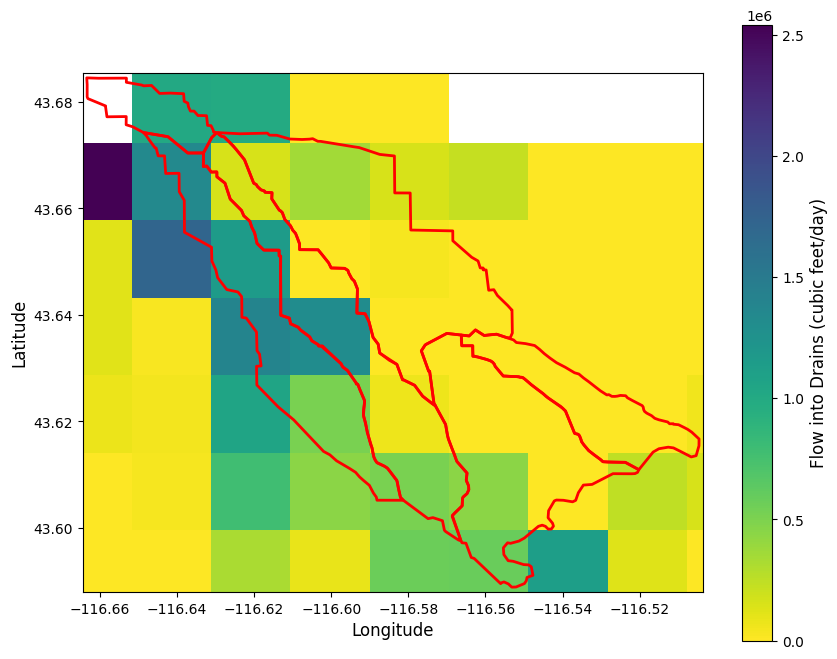

In [25]:
# Visualize the Overlap between Mason Drainage and the TVGWF
# Mason Creek only

reach_gdf = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp')

if reach_gdf.crs != 'EPSG:4326':
    reach_gdf = reach_gdf.to_crs('EPSG:4326')
minx, miny, maxx, maxy = reach_gdf.total_bounds
buffer = 0.001
cropped_extent = [minx - buffer, maxx + buffer, miny - buffer, maxy + buffer]
drn_arr_lay1 = np.abs(drn_arr_lay1)
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(drn_arr_lay1, cmap='viridis_r', extent=[-117.103530233726, -115.768691366538, 43.1778883119514, 44.1083], origin='upper')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Flow into Drains (cubic feet/day)', fontsize=12)
reach_gdf.plot(ax=ax, edgecolor='red', linewidth=2, facecolor='none')

ax.set_xlim(cropped_extent[0], cropped_extent[1])
ax.set_ylim(cropped_extent[2], cropped_extent[3])
plt.title('', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.show()

In [ ]:
# ---------------------------- #
# GW contribution to each reach
# ---------------------------- #


# units: cubic feet per day

reach_gdf = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp')

# Ensure CRS is defined
if reach_gdf.crs is None:
    reach_gdf.set_crs("EPSG:4326", inplace=True)

# Function to process each stress period
def process_stress_period(stress_period, drn_out_arr, min_lon, min_lat, max_lon, max_lat, reach_gdf):
    # Extract the masked array for the current stress period
    drn_ma_i = drn_out_arr[stress_period]
    drn_arr_i = drn_ma_i.filled(np.nan)
    drn_arr_lay1 = drn_arr_i[0, :, :]  # Top layer values

    # Grid dimensions
    nrows, ncols = drn_arr_lay1.shape
    cell_width = (max_lon - min_lon) / ncols
    cell_height = (max_lat - min_lat) / nrows

    # Create grid of polygons and values
    polygons = []
    values = []
    for i in range(nrows):
        for j in range(ncols):
            x1 = min_lon + j * cell_width
            y1 = max_lat - i * cell_height
            x2 = x1 + cell_width
            y2 = y1 - cell_height
            polygons.append(Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]))
            values.append(drn_arr_lay1[i, j])
    grid_gdf = gpd.GeoDataFrame({'geometry': polygons, 'value': values}, crs="EPSG:4326")

    # Ensure CRS match
    if grid_gdf.crs != reach_gdf.crs:
        reach_gdf = reach_gdf.to_crs(grid_gdf.crs)

    # Initialize results for this stress period
    stress_results = []

    # Process each reach
    for _, reach_row in reach_gdf.iterrows():
        reach_geom = reach_row.geometry
        reach_name = reach_row['Reach']  # Replace with actual column name

        # Calculate intersection of the reach with the grid cells
        grid_gdf['intersection'] = grid_gdf.geometry.intersection(reach_geom)
        grid_gdf['intersection_area'] = grid_gdf['intersection'].area
        grid_gdf['cell_area'] = grid_gdf.geometry.area
        grid_gdf['weight'] = grid_gdf['intersection_area'] / grid_gdf['cell_area']
        grid_gdf['weighted_value'] = grid_gdf['value'] * grid_gdf['weight']

        # Sum the weighted values for the reach
        reach_sum = grid_gdf['weighted_value'].sum()

        # Store the result
        stress_results.append({'Stress Period': stress_period, 'Reach': reach_name, 'Flow (cfperday)': reach_sum})

    return stress_results

# Define bounding box
min_lon, min_lat, max_lon, max_lat = -117.103530233726, 43.1778883119514, -115.768691366538, 44.1083

# Initialize final results
all_results = []

# Loop through stress periods
for stress_period in range(300, 361):
    stress_results = process_stress_period(stress_period, drn_out_arr, min_lon, min_lat, max_lon, max_lat, reach_gdf)
    all_results.extend(stress_results)

# Convert to DataFrame
results_df = pd.DataFrame(all_results)
results_df.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_cfday.csv', index=False)
# Display or save results
print(results_df)

<ipython-input-7-6768c57d30c5>:53: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['intersection_area'] = grid_gdf['intersection'].area
<ipython-input-7-6768c57d30c5>:54: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['cell_area'] = grid_gdf.geometry.area
<ipython-input-7-6768c57d30c5>:53: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['intersection_area'] = grid_gdf['intersection'].area
<ipython-input-7-6768c57d30c5>:54: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to

     Stress Period          Reach  Flow (cfperday)
0              300    Noble Drain    -1.001167e+06
1              300   Purdum Reach    -8.182907e+03
2              300  Solomon Reach    -2.008729e+06
3              300        Reach 1    -2.292895e+05
4              300        Reach 2    -2.510811e+05
..             ...            ...              ...
361            360   Purdum Reach    -5.238582e+03
362            360  Solomon Reach    -1.746103e+06
363            360        Reach 1    -1.257237e+05
364            360        Reach 2    -1.963767e+05
365            360        Reach 3    -3.742834e+05

[366 rows x 3 columns]


In [ ]:
# ---------------------------- #
# GW contribution to each reach
# ---------------------------- #

# units: AF/day

#blank cell in half of Reach 3

def process_stress_period(stress_period, drn_out_arr, min_lon, min_lat, max_lon, max_lat, reach_gdf):
    drn_ma_i = drn_out_arr[stress_period]
    drn_arr_i = drn_ma_i.filled(np.nan)
    drn_arr_lay1 = drn_arr_i[0, :, :]
    nrows, ncols = drn_arr_lay1.shape
    cell_width = (max_lon - min_lon) / ncols
    cell_height = (max_lat - min_lat) / nrows
    polygons = []
    values = []
    for i in range(nrows):
        for j in range(ncols):
            x1 = min_lon + j * cell_width
            y1 = max_lat - i * cell_height
            x2 = x1 + cell_width
            y2 = y1 - cell_height
            polygons.append(Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]))
            # Convert cfd to acre-feet per month (using 30.4375 days)
            values.append(drn_arr_lay1[i, j] * 30 / 43560)
    grid_gdf = gpd.GeoDataFrame({'geometry': polygons, 'value': values}, crs="EPSG:4326")
    if grid_gdf.crs != reach_gdf.crs:
        reach_gdf = reach_gdf.to_crs(grid_gdf.crs)

    stress_results = []
    for _, reach_row in reach_gdf.iterrows():
        reach_geom = reach_row.geometry
        reach_name = reach_row['Reach']
        grid_gdf['intersection'] = grid_gdf.geometry.intersection(reach_geom)
        grid_gdf['intersection_area'] = grid_gdf['intersection'].area
        grid_gdf['cell_area'] = grid_gdf.geometry.area
        grid_gdf['weight'] = grid_gdf['intersection_area'] / grid_gdf['cell_area']
        grid_gdf['weighted_value'] = grid_gdf['value'] * grid_gdf['weight']

        # Sum the weighted values for the reach
        reach_sum = grid_gdf['weighted_value'].sum()
        stress_results.append({'Stress Period': stress_period, 'Reach': reach_name, 'Weighted Sum': reach_sum})

    return stress_results

# Define bounding box of Mason
min_lon, min_lat, max_lon, max_lat = -117.103530233726, 43.1778883119514, -115.768691366538, 44.1083


all_results = []
for stress_period in range(300, 361):
    stress_results = process_stress_period(stress_period, drn_out_arr, min_lon, min_lat, max_lon, max_lat, reach_gdf)
    all_results.extend(stress_results)

results_df = pd.DataFrame(all_results)
results_df.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_afpermonth.csv', index=False)
print(results_df)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-13-b7cb4500d7f6>:46: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['intersection_area'] = grid_gdf['intersection'].area
<ipython-input-13-b7cb4500d7f6>:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['cell_area'] = grid_gdf.geometry.area
<ipython-input-13-b7cb4500d7f6>:46: UserWarning: Geometry is in a geographic CRS. Results from 'ar

     Stress Period          Reach  Weighted Sum
0              300    Noble Drain   -689.508967
1              300   Purdum Reach     -5.635611
2              300  Solomon Reach  -1383.422271
3              300        Reach 1   -157.912860
4              300        Reach 2   -172.920875
..             ...            ...           ...
361            360   Purdum Reach     -3.607839
362            360  Solomon Reach  -1202.549972
363            360        Reach 1    -86.586571
364            360        Reach 2   -135.245644
365            360        Reach 3   -257.770960

[366 rows x 3 columns]


In [ ]:
# ---------------------------- #
# GW contribution to each reach
# ---------------------------- #

# units: AF/day

#blank cell in half of Reach 3 filled with value of adjacent cell

from scipy.ndimage import generic_filter
def process_stress_period(stress_period, drn_out_arr, min_lon, min_lat, max_lon, max_lat, reach_gdf):
    drn_ma_i = drn_out_arr[stress_period]
    drn_arr_i = drn_ma_i.filled(np.nan)
    drn_arr_lay1 = drn_arr_i[0, :, :]
    def fill_nearest(values):
        center_value = values[len(values) // 2]
        if np.isnan(center_value):
            return np.nanmean(values)
        return center_value

    filled_drn_arr = generic_filter(drn_arr_lay1, fill_nearest, size=3, mode='nearest')
    nrows, ncols = filled_drn_arr.shape
    cell_width = (max_lon - min_lon) / ncols
    cell_height = (max_lat - min_lat) / nrows
    polygons = []
    values = []
    for i in range(nrows):
        for j in range(ncols):
            x1 = min_lon + j * cell_width
            y1 = max_lat - i * cell_height
            x2 = x1 + cell_width
            y2 = y1 - cell_height
            polygons.append(Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]))
            values.append(filled_drn_arr[i, j] * 30 / 43560)
    grid_gdf = gpd.GeoDataFrame({'geometry': polygons, 'value': values}, crs="EPSG:4326")
    if grid_gdf.crs != reach_gdf.crs:
        reach_gdf = reach_gdf.to_crs(grid_gdf.crs)
    stress_results = []
    for _, reach_row in reach_gdf.iterrows():
        reach_geom = reach_row.geometry
        reach_name = reach_row['Reach']
        grid_gdf['intersection'] = grid_gdf.geometry.intersection(reach_geom)
        grid_gdf['intersection_area'] = grid_gdf['intersection'].area
        grid_gdf['cell_area'] = grid_gdf.geometry.area
        grid_gdf['weight'] = grid_gdf['intersection_area'] / grid_gdf['cell_area']
        grid_gdf['weighted_value'] = grid_gdf['value'] * grid_gdf['weight']
        reach_sum = grid_gdf['weighted_value'].sum()
        stress_results.append({'Stress Period': stress_period, 'Reach': reach_name, 'Weighted Sum': reach_sum})

    return stress_results

min_lon, min_lat, max_lon, max_lat = -117.103530233726, 43.1778883119514, -115.768691366538, 44.1083
all_results = []
for stress_period in range(300, 361):
    stress_results = process_stress_period(stress_period, drn_out_arr, min_lon, min_lat, max_lon, max_lat, reach_gdf)
    all_results.extend(stress_results)
results_df = pd.DataFrame(all_results)
results_df.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_afpermonth.csv', index=False)
print(results_df)

<ipython-input-10-d87415717e63>:42: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['intersection_area'] = grid_gdf['intersection'].area
<ipython-input-10-d87415717e63>:43: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['cell_area'] = grid_gdf.geometry.area
<ipython-input-10-d87415717e63>:42: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['intersection_area'] = grid_gdf['intersection'].area
<ipython-input-10-d87415717e63>:43: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometrie

     Stress Period          Reach  Weighted Sum
0              300    Noble Drain   -689.508967
1              300   Purdum Reach     -5.635611
2              300  Solomon Reach  -1383.422271
3              300        Reach 1   -157.912860
4              300        Reach 2   -172.920875
..             ...            ...           ...
361            360   Purdum Reach     -3.607839
362            360  Solomon Reach  -1202.549972
363            360        Reach 1    -86.586571
364            360        Reach 2   -135.245644
365            360        Reach 3   -365.688794

[366 rows x 3 columns]


In [ ]:
# -------------------------------------- #
# Create Dataset for input into WB images
# -------------------------------------- #

df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_cfday.csv')

# Define the starting year and the total number of stress periods
start_year = 1986
total_stress_periods = 360

# Generate a sequence of dates starting from January of the starting year
dates = pd.date_range(start=f"{start_year}-01-01", periods=total_stress_periods, freq='MS')

# Create a new DataFrame mapping stress periods to months and years
dates_df = pd.DataFrame({
    'Stress Period': range(1, total_stress_periods + 1),
    'Month': dates.month,
    'Year': dates.year
})

# Merge the new date information into the original DataFrame
result_df = df.merge(dates_df, on='Stress Period')

# Correct conversion from CFD to KAF/month
conversion_factor_kaf = (30.4375 / 43560) / 1000  # CFD to KAF/month
result_df['Flow (KAF)'] = result_df['Flow (cfperday)'] * conversion_factor_kaf

result_df.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/gw_final_kaf.csv', index=False)

## Make images from GW data

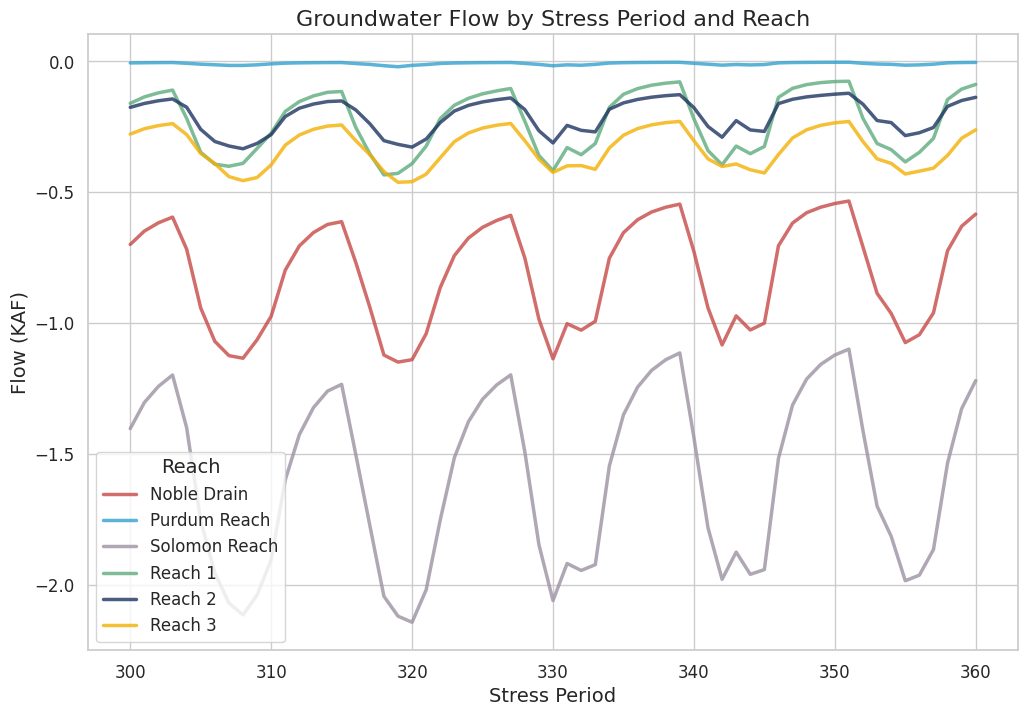

In [ ]:
# -------------------------------- #
# Figure: Reach GW Gains per month
# -------------------------------- #

# This plot is from the perspective of the GW (showing GW losses)

results_df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/gw_final_kaf.csv')

sns.set(style="whitegrid")

# for Reaches
reach_palette = {
    "Reach 1": "#5CAB7D",
    "Reach 2": "#1D3461",
    "Reach 3": "#F3AF04",
    "Purdum Reach": "#32A0CF",
    "Solomon Reach": "#9D91A3",
    "Noble Drain": "#C64846"
}

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=results_df,
    x='Stress Period',
    y='Flow (KAF)',
    hue='Reach',
    palette=reach_palette,
    linewidth=2.5,
    alpha=0.8
)

plt.title('Groundwater Flow by Stress Period and Reach', fontsize=16)
plt.xlabel('Stress Period', fontsize=14)
plt.ylabel('Flow (KAF)', fontsize=14)
plt.legend(title='Reach', fontsize=12, title_fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

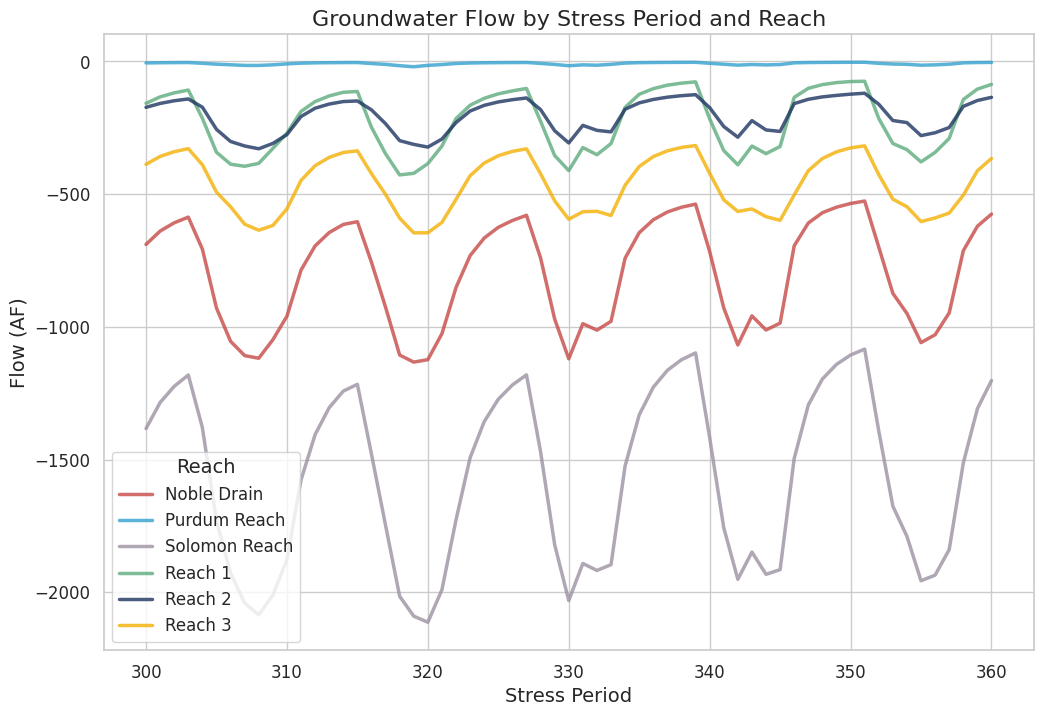

In [ ]:
# -------------------------------- #
# Figure: Reach GW Gains per month
# -------------------------------- #

# This plot is from the perspective of the GW (showing GW losses)

results_df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_afpermonth.csv')

sns.set(style="whitegrid")

# for Reaches
reach_palette = {
    "Reach 1": "#5CAB7D",
    "Reach 2": "#1D3461",
    "Reach 3": "#F3AF04",
    "Purdum Reach": "#32A0CF",
    "Solomon Reach": "#9D91A3",
    "Noble Drain": "#C64846"
}

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=results_df,
    x='Stress Period',
    y='Weighted Sum',
    hue='Reach',
    palette=reach_palette,
    linewidth=2.5,
    alpha=0.8
)

plt.title('Groundwater Flow by Stress Period and Reach', fontsize=16)
plt.xlabel('Stress Period', fontsize=14)
plt.ylabel('Flow (AF)', fontsize=14)
plt.legend(title='Reach', fontsize=12, title_fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

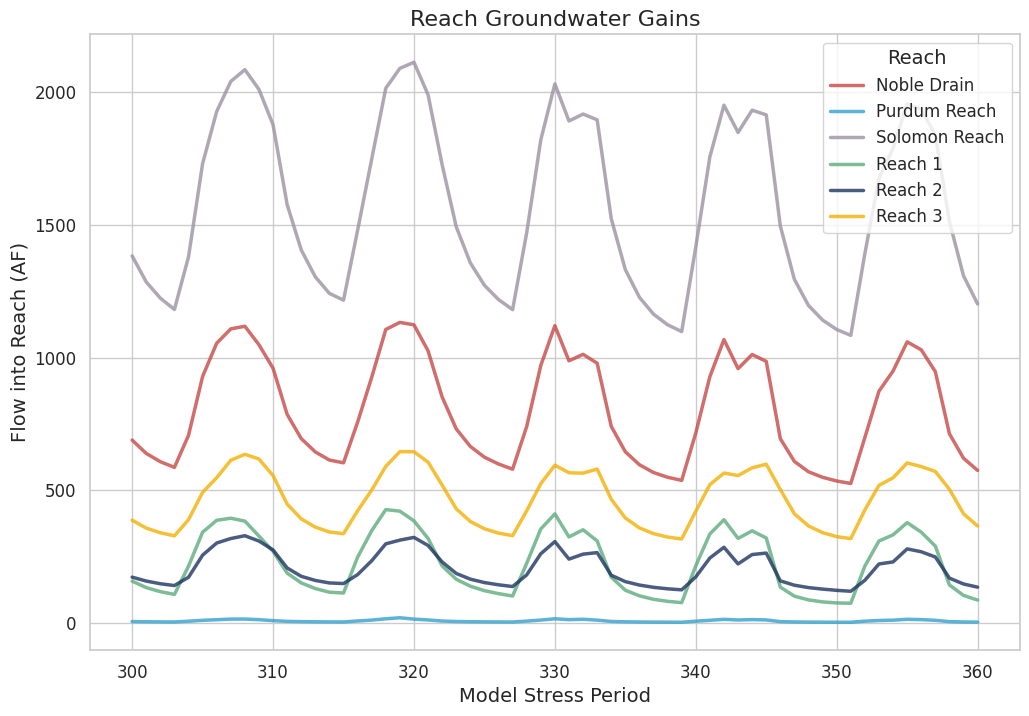

In [ ]:
# -------------------------------- #
# Figure: Reach GW Gains per month
# -------------------------------- #

# This plot is from the perspective of the reach (showing reach gains)


results_df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_afpermonth.csv')

# Take the absolute value of the 'Weighted Sum' column
results_df['Weighted Sum'] = results_df['Weighted Sum'].abs()

# Set up the seaborn style
sns.set(style="whitegrid")

# Define the palette for the reaches
reach_palette = {
    "Reach 1": "#5CAB7D",
    "Reach 2": "#1D3461",
    "Reach 3": "#F3AF04",
    "Purdum Reach": "#32A0CF",
    "Solomon Reach": "#9D91A3",
    "Noble Drain": "#C64846"
}

# Create the plot
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=results_df,
    x='Stress Period',
    y='Weighted Sum',
    hue='Reach',
    palette=reach_palette,
    linewidth=2.5,
    alpha=0.8
)

# Customize the plot
plt.title('Reach Groundwater Gains', fontsize=16)
plt.xlabel('Model Stress Period', fontsize=14)
plt.ylabel('Flow into Reach (AF)', fontsize=14)
plt.legend(title='Reach', fontsize=12, title_fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.show()

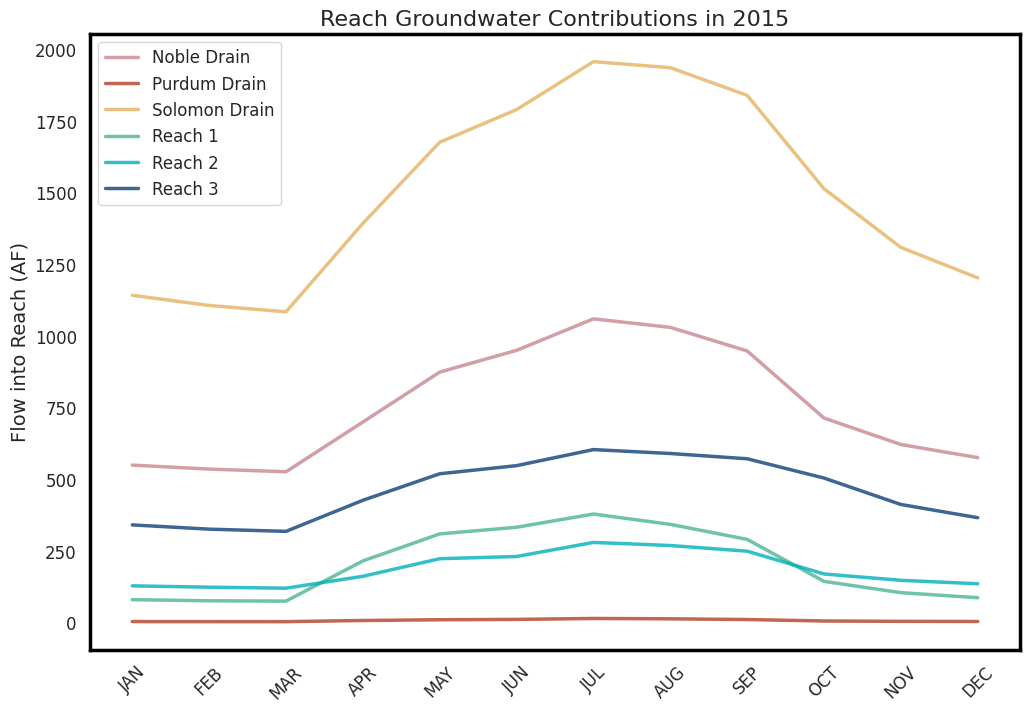

In [ ]:
# -------------------------------- #
# Figure: Reach GW Gains per month
# -------------------------------- #

# 2015 data only
#kaf

results_df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_afpermonth.csv')
results_df["Reach"] = results_df["Reach"].replace({"Solomon Reach": "Solomon Drain"})
results_df["Reach"] = results_df["Reach"].replace({"Purdum Reach": "Purdum Drain"})

results_df['Weighted Sum'] = results_df['Weighted Sum'].abs()


results_df = results_df[(results_df['Stress Period'] >= 349) & (results_df['Stress Period'] <= 360)]


month_mapping = {
    349: 'JAN', 350: 'FEB', 351: 'MAR', 352: 'APR', 353: 'MAY', 354: 'JUN',
    355: 'JUL', 356: 'AUG', 357: 'SEP', 358: 'OCT', 359: 'NOV', 360: 'DEC'
}
results_df['Month'] = results_df['Stress Period'].map(month_mapping)


sns.set_style("white")

reach_palette = {
    "Reach 1": "#4CB495",
    "Reach 2": "#00AFB9",
    "Reach 3": "#0F3E78",
    "Noble Drain": "#C6878F",
    "Solomon Drain": "#E4B363",
    "Purdum Drain": "#AE4027"
}

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=results_df,
    x='Month',
    y='Weighted Sum',
    hue='Reach',
    palette=reach_palette,
    linewidth=2.5,
    alpha=0.8
)

plt.title('Reach Groundwater Contributions in 2015', fontsize=16)
plt.xlabel('', fontsize=14)
plt.ylabel('Flow into Reach (AF)', fontsize=14)
plt.legend(title='', fontsize=12, title_fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

ax = plt.gca()
ax.spines['top'].set_linewidth(2.5)
ax.spines['top'].set_color('black')
ax.spines['right'].set_linewidth(2.5)
ax.spines['right'].set_color('black')
ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('black')

ax.tick_params(axis='x', length=6, width=1.5, direction='out')
ax.tick_params(axis='y', length=6, width=1.5, direction='out')


plt.savefig('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw2015.png', dpi=300, bbox_inches='tight')
plt.show()

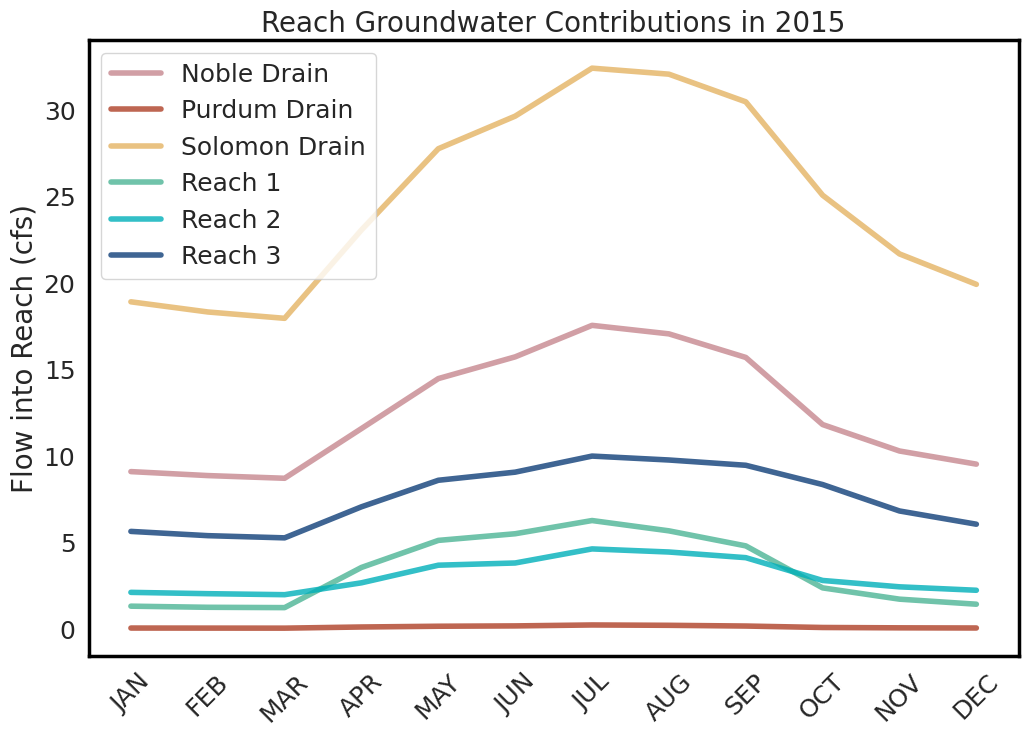

In [ ]:
# -------------------------------- #
# Figure: Reach GW Gains per month
# -------------------------------- #

# 2015 data only
#cfs


results_df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_afpermonth.csv')
results_df["Reach"] = results_df["Reach"].replace({"Solomon Reach": "Solomon Drain"})
results_df["Reach"] = results_df["Reach"].replace({"Purdum Reach": "Purdum Drain"})
results_df['Weighted Sum'] = results_df['Weighted Sum'].abs()


days_in_month = 30.436875  # Average number of days in a month
af_to_cfs_conversion = 43560 / (days_in_month * 24 * 60 * 60)  # 1 AF = 43560 cubic feet
results_df['Weighted Sum (cfs)'] = results_df['Weighted Sum'] * af_to_cfs_conversion
results_df = results_df[(results_df['Stress Period'] >= 349) & (results_df['Stress Period'] <= 360)]
month_mapping = {
    349: 'JAN', 350: 'FEB', 351: 'MAR', 352: 'APR', 353: 'MAY', 354: 'JUN',
    355: 'JUL', 356: 'AUG', 357: 'SEP', 358: 'OCT', 359: 'NOV', 360: 'DEC'
}
results_df['Month'] = results_df['Stress Period'].map(month_mapping)

sns.set_style("white")
reach_palette = {
    "Reach 1": "#4CB495",
    "Reach 2": "#00AFB9",
    "Reach 3": "#0F3E78",
    "Noble Drain": "#C6878F",
    "Solomon Drain": "#E4B363",
    "Purdum Drain": "#AE4027"
}


plt.figure(figsize=(12, 8))
sns.lineplot(
    data=results_df,
    x='Month',
    y='Weighted Sum (cfs)',
    hue='Reach',
    palette=reach_palette,
    linewidth=4.0,
    alpha=0.8
)

plt.title('Reach Groundwater Contributions in 2015', fontsize=20)
plt.xlabel('', fontsize=14)
plt.ylabel('Flow into Reach (cfs)', fontsize=20)
plt.legend(title='', fontsize=18, title_fontsize=20)
plt.xticks(fontsize=18, rotation=45)
plt.yticks(fontsize=18)

ax = plt.gca()
ax.spines['top'].set_linewidth(2.5)
ax.spines['top'].set_color('black')
ax.spines['right'].set_linewidth(2.5)
ax.spines['right'].set_color('black')
ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('black')
ax.tick_params(axis='x', length=6, width=1.5, direction='out')
ax.tick_params(axis='y', length=6, width=1.5, direction='out')

plt.savefig('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw2015_cfs_widerlines.png', dpi=300, bbox_inches='tight')
plt.show()

<ipython-input-23-08a72b841e33>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:700:

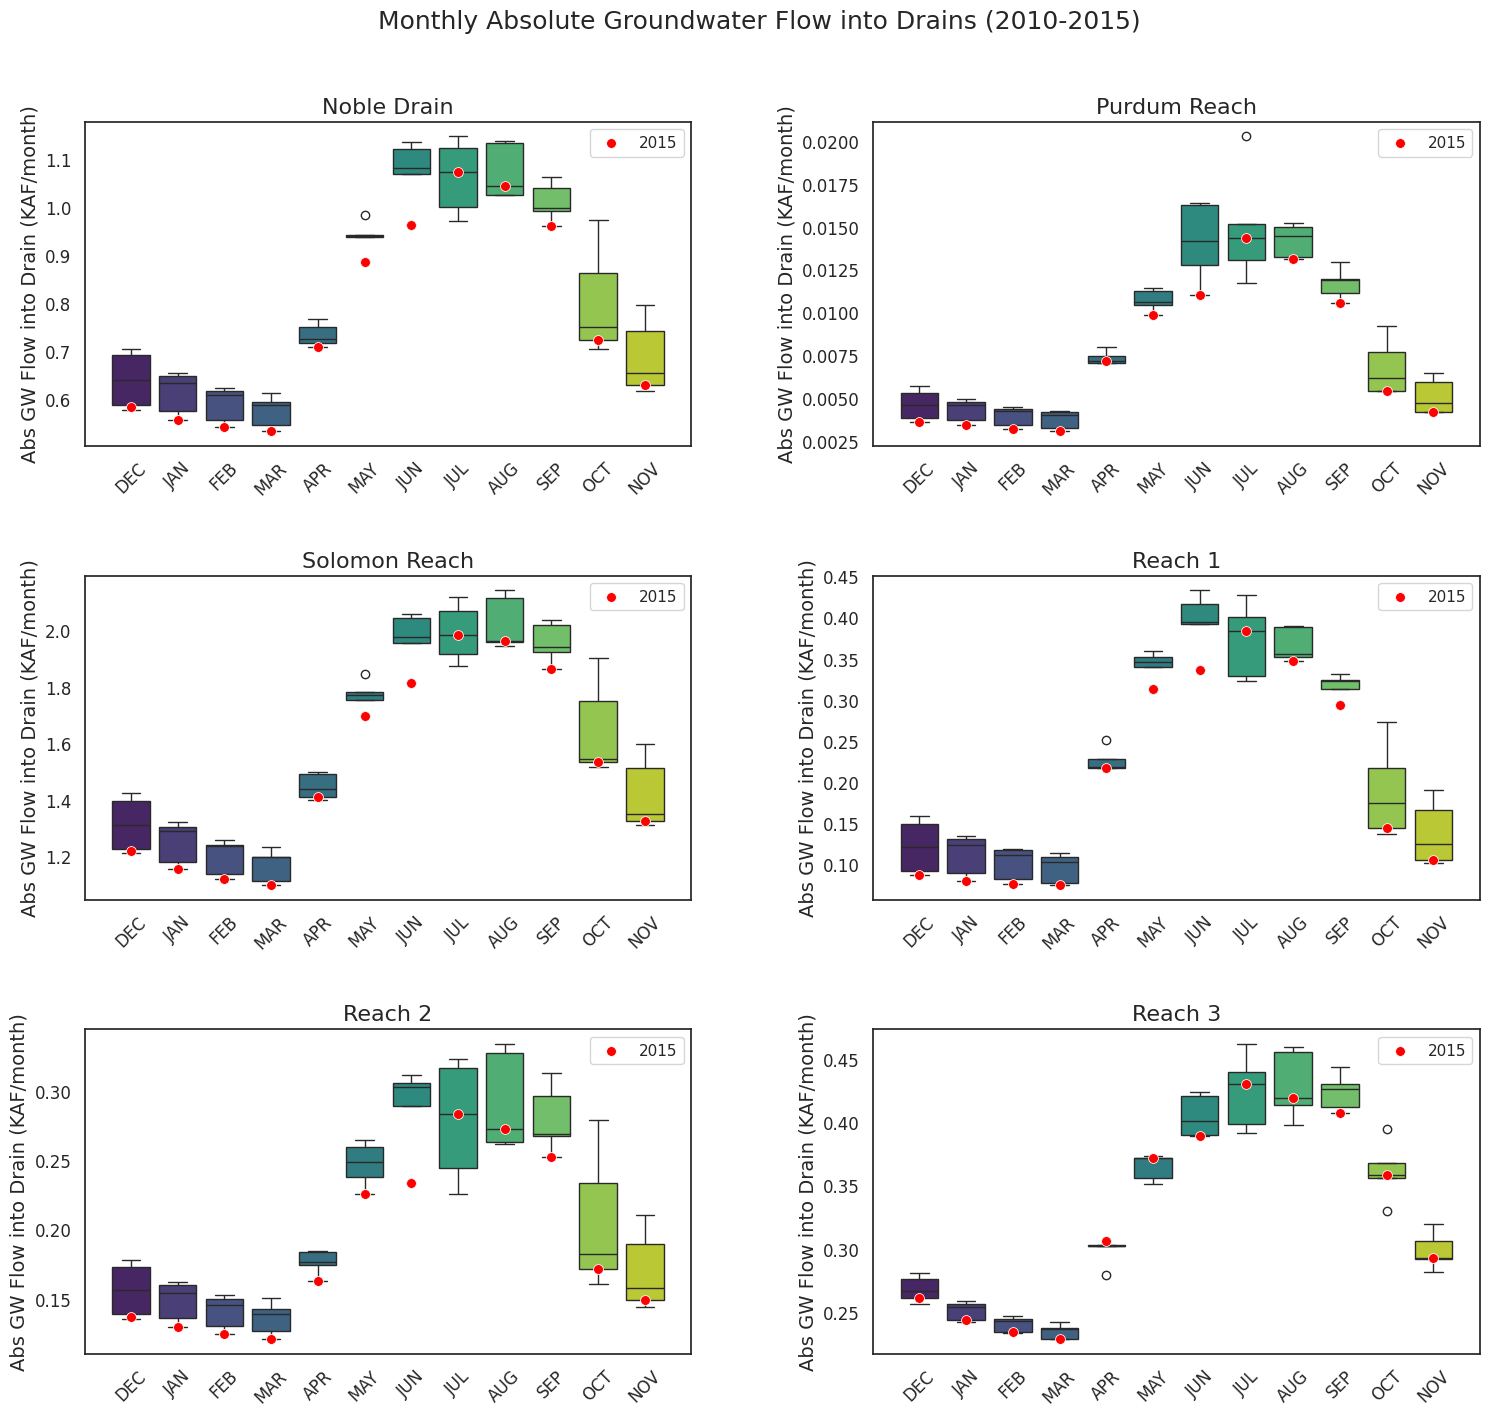

In [ ]:
# -------------------------------- #
# Figure: Boxplot of average gw to reach
# -------------------------------- #

# 2011 to 2015 data

# KAF
df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_cfday.csv')
start_year = 1986
total_stress_periods = 360

dates = pd.date_range(start=f"{start_year}-01-01", periods=total_stress_periods, freq='MS')

dates_df = pd.DataFrame({
    'Stress Period': range(1, total_stress_periods + 1),
    'Month': dates.month,
    'Year': dates.year
})

result_df = df.merge(dates_df, on='Stress Period')

result_df['Month'] = result_df['Month'].apply(lambda x: calendar.month_abbr[x].upper())

conversion_factor_kaf_month = 0.0000229568 * 0.001 * 30.436875
result_df['Flow (KAF/month)'] = result_df['Flow (cfperday)'] * conversion_factor_kaf_month
result_df['Flow (Abs KAF/month)'] = result_df['Flow (KAF/month)'].abs()

filtered_df = result_df[(result_df['Year'] >= 2010) & (result_df['Year'] <= 2015)]

unique_reaches = filtered_df['Reach'].unique()

fig = plt.figure(figsize=(18, 16))
gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.3, hspace=0.4)

for idx, reach in enumerate(unique_reaches):
    ax = fig.add_subplot(gs[idx])
    reach_data = filtered_df[filtered_df['Reach'] == reach]
    reach_data_2015 = reach_data[reach_data['Year'] == 2015]  # Filter data for 2015
    sns.boxplot(
        data=reach_data,
        x='Month',
        y='Flow (Abs KAF/month)',
        palette='viridis',
        ax=ax
    )
    sns.scatterplot(
        data=reach_data_2015,
        x='Month',
        y='Flow (Abs KAF/month)',
        color='red',
        label='2015',
        s=50,
        zorder=5,
        ax=ax
    )
    ax.set_title(f'{reach}', fontsize=16)
    ax.set_xlabel('', fontsize=14)
    ax.set_ylabel('Abs GW Flow into Drain (KAF/month)', fontsize=14)
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
fig.suptitle('Monthly Absolute Groundwater Flow into Drains (2010-2015)', fontsize=18, y=0.95)
plt.show()

<ipython-input-25-5f97b780df0e>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:700:

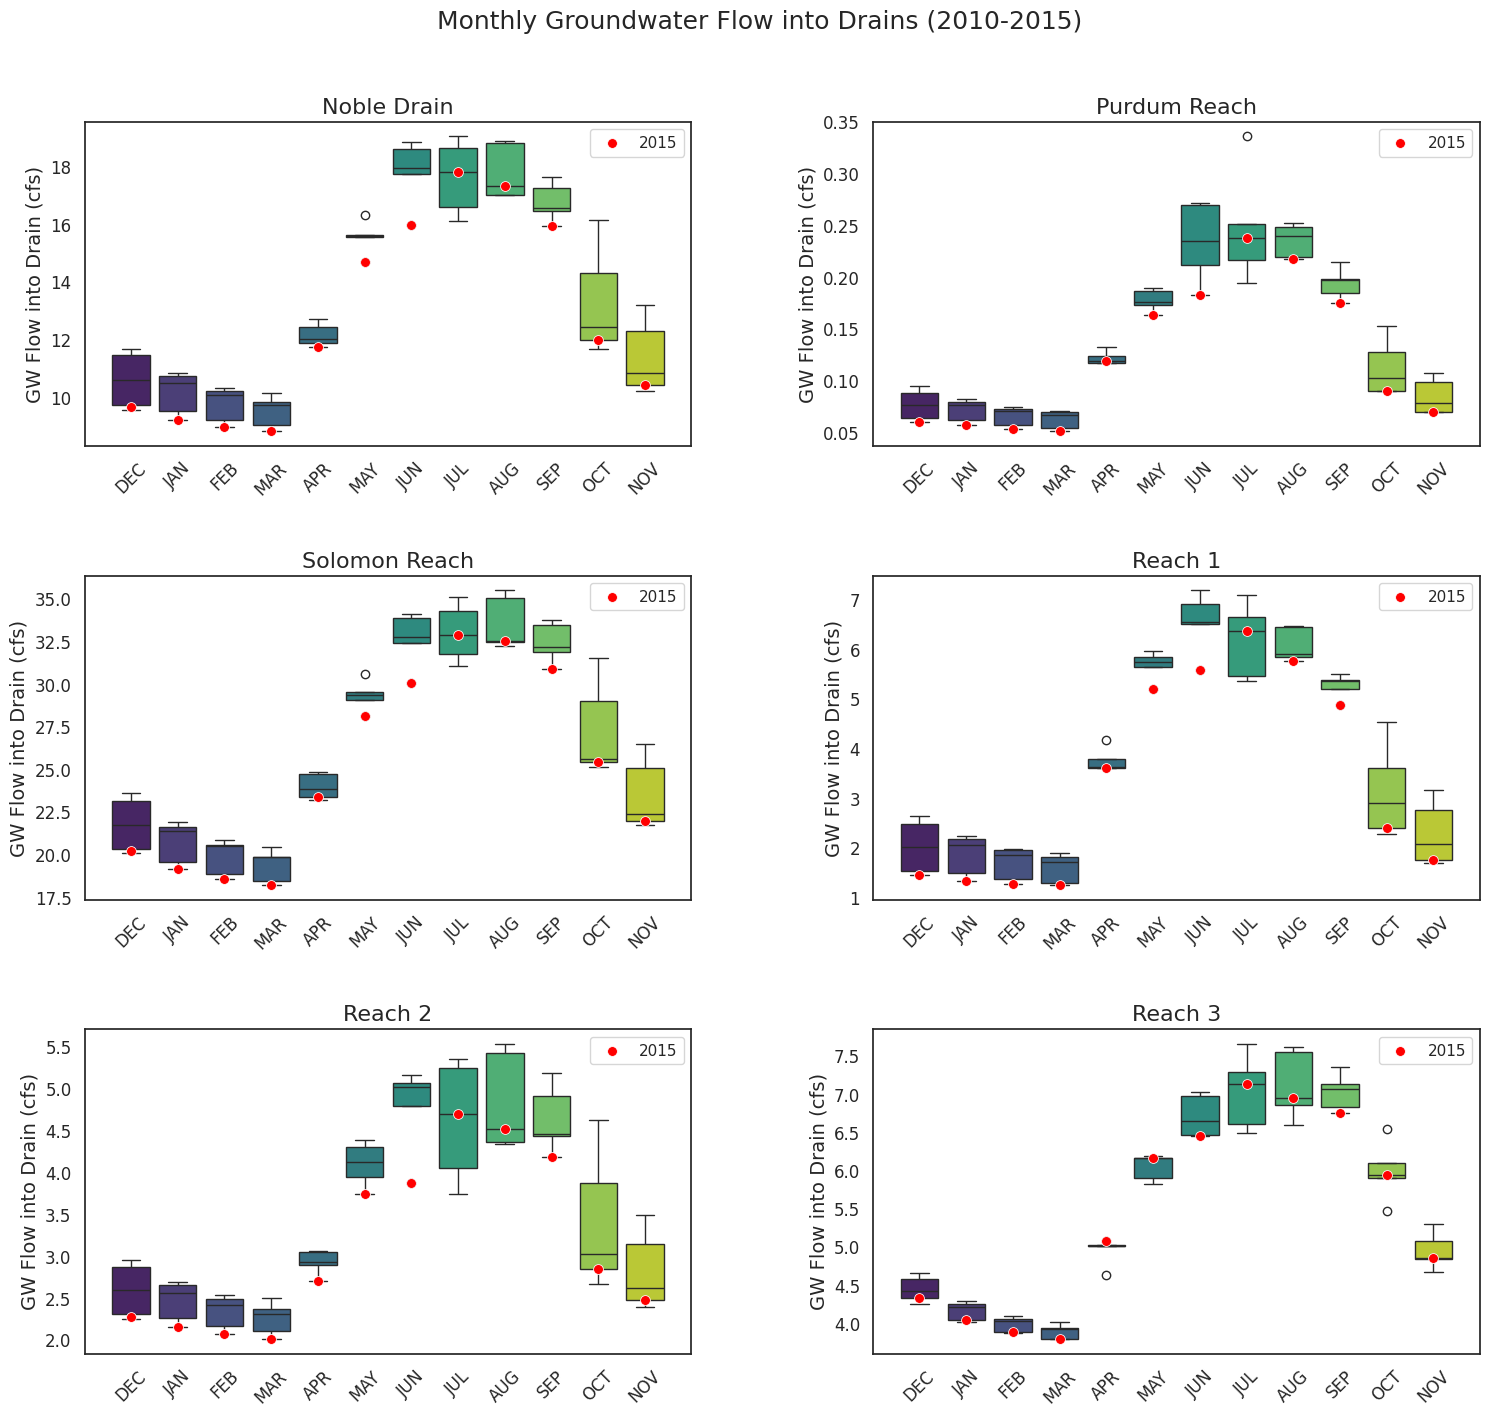

In [ ]:
# -------------------------------- #
# Figure: Boxplot of average gw to reach
# -------------------------------- #

# 2011 to 2015 data

# cfs

df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_cfday.csv')

start_year = 1986
total_stress_periods = 360

dates = pd.date_range(start=f"{start_year}-01-01", periods=total_stress_periods, freq='MS')

dates_df = pd.DataFrame({
    'Stress Period': range(1, total_stress_periods + 1),
    'Month': dates.month,
    'Year': dates.year
})


result_df = df.merge(dates_df, on='Stress Period')

result_df['Month'] = result_df['Month'].apply(lambda x: calendar.month_abbr[x].upper())

# Convert Flow from cubic feet per day (cfperday) to cubic feet per second (cfs)
conversion_factor_cfs = 1 / (24 * 60 * 60)  # 1 day = 86400 seconds
result_df['Flow (cfs)'] = result_df['Flow (cfperday)'] * conversion_factor_cfs
result_df['Flow (Abs cfs)'] = result_df['Flow (cfs)'].abs()

filtered_df = result_df[(result_df['Year'] >= 2010) & (result_df['Year'] <= 2015)]

unique_reaches = filtered_df['Reach'].unique()

fig = plt.figure(figsize=(18, 16))
gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.3, hspace=0.4)

for idx, reach in enumerate(unique_reaches):
    ax = fig.add_subplot(gs[idx])
    reach_data = filtered_df[filtered_df['Reach'] == reach]
    reach_data_2015 = reach_data[reach_data['Year'] == 2015]
    sns.boxplot(
        data=reach_data,
        x='Month',
        y='Flow (Abs cfs)',
        palette='viridis',
        ax=ax
    )

    sns.scatterplot(
        data=reach_data_2015,
        x='Month',
        y='Flow (Abs cfs)',
        color='red',
        label='2015',
        s=50,
        zorder=5,
        ax=ax
    )
    ax.set_title(f'{reach}', fontsize=16)
    ax.set_xlabel('', fontsize=14)
    ax.set_ylabel('GW Flow into Drain (cfs)', fontsize=14)
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
fig.suptitle('Monthly Groundwater Flow into Drains (2010-2015)', fontsize=18, y=0.95)
plt.show()

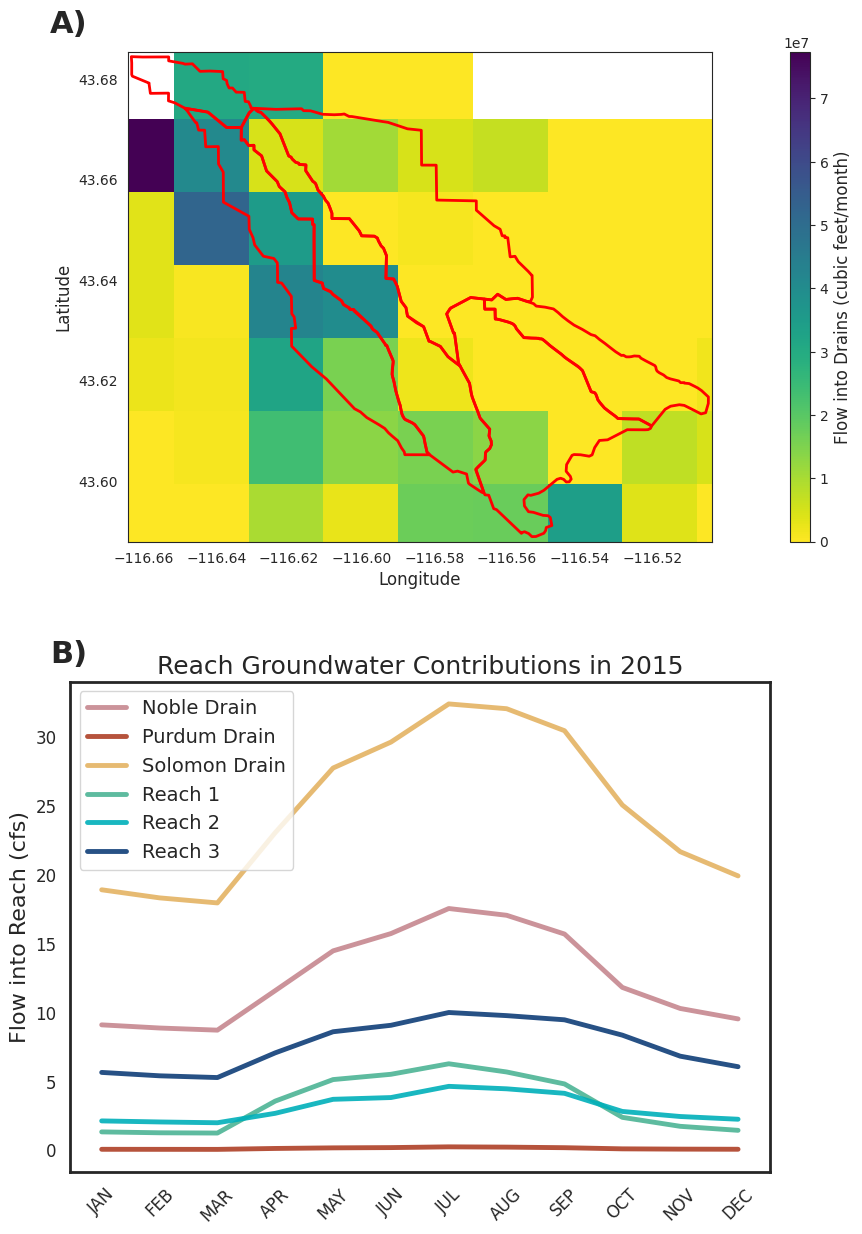

In [37]:

reach_gdf = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp')
if reach_gdf.crs != 'EPSG:4326':
    reach_gdf = reach_gdf.to_crs('EPSG:4326')

minx, miny, maxx, maxy = reach_gdf.total_bounds
buffer = 0.001
cropped_extent = [minx - buffer, maxx + buffer, miny - buffer, maxy + buffer]
drn_arr_lay1 = np.abs(drn_arr_lay1) * 30.44  # Convert to cubic feet/month

results_df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_afpermonth.csv')
results_df["Reach"] = results_df["Reach"].replace({"Solomon Reach": "Solomon Drain", "Purdum Reach": "Purdum Drain"})
results_df['Weighted Sum'] = results_df['Weighted Sum'].abs()

days_in_month = 30.436875
af_to_cfs = 43560 / (days_in_month * 24 * 60 * 60)
results_df['Weighted Sum (cfs)'] = results_df['Weighted Sum'] * af_to_cfs
results_df = results_df[(results_df['Stress Period'] >= 349) & (results_df['Stress Period'] <= 360)]

month_mapping = {
    349: 'JAN', 350: 'FEB', 351: 'MAR', 352: 'APR', 353: 'MAY', 354: 'JUN',
    355: 'JUL', 356: 'AUG', 357: 'SEP', 358: 'OCT', 359: 'NOV', 360: 'DEC'
}
results_df['Month'] = results_df['Stress Period'].map(month_mapping)

reach_palette = {
    "Reach 1": "#4CB495",
    "Reach 2": "#00AFB9",
    "Reach 3": "#0F3E78",
    "Noble Drain": "#C6878F",
    "Solomon Drain": "#E4B363",
    "Purdum Drain": "#AE4027"
}


fig = plt.figure(figsize=(10, 14))

# Panel A: Square map
ax1 = fig.add_axes([0.1, 0.55, 0.7, 0.35])
im = ax1.imshow(drn_arr_lay1, cmap='viridis_r',
                extent=[-117.103530233726, -115.768691366538, 43.1778883119514, 44.1083],
                origin='upper', aspect='equal')
reach_gdf.plot(ax=ax1, edgecolor='red', linewidth=2, facecolor='none')
ax1.set_xlim(cropped_extent[0], cropped_extent[1])
ax1.set_ylim(cropped_extent[2], cropped_extent[3])
ax1.set_xlabel('Longitude', fontsize=12)
ax1.set_ylabel('Latitude', fontsize=12)
fig.text(0.08, 0.93, "A)", fontsize=22, fontweight='bold', ha='left', va='top')


cax = fig.add_axes([0.82, 0.55, 0.02, 0.35])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('Flow into Drains (cubic feet/month)', fontsize=12)

ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.35])
sns.set_style("white")
sns.lineplot(
    data=results_df,
    x='Month',
    y='Weighted Sum (cfs)',
    hue='Reach',
    palette=reach_palette,
    linewidth=3.5,
    alpha=0.9,
    ax=ax2
)

ax2.set_title('Reach Groundwater Contributions in 2015', fontsize=18)
ax2.set_xlabel('', fontsize=14)
ax2.set_ylabel('Flow into Reach (cfs)', fontsize=16)
ax2.legend(title='', fontsize=14, title_fontsize=16)
ax2.tick_params(axis='x', labelsize=12, rotation=45)
ax2.tick_params(axis='y', labelsize=12)
for spine in ax2.spines.values():
    spine.set_linewidth(2)
ax2.tick_params(axis='x', length=6, width=1.5, direction='out')
ax2.tick_params(axis='y', length=6, width=1.5, direction='out')
fig.text(0.08, 0.48, "B)", fontsize=22, fontweight='bold', ha='left', va='top')

plt.show()

## Extract TVGWFM Data for the entire study area ("allmason")

In [ ]:
# ---------------------------- #
# GW contribution in all of Mason
# ---------------------------- #

# Output units: AF/day
def process_stress_period(stress_period, drn_out_arr, min_lon, min_lat, max_lon, max_lat, reach_gdf):
    drn_ma_i = drn_out_arr[stress_period]
    drn_arr_i = drn_ma_i.filled(np.nan)
    drn_arr_lay1 = drn_arr_i[0, :, :]
    nrows, ncols = drn_arr_lay1.shape
    cell_width = (max_lon - min_lon) / ncols
    cell_height = (max_lat - min_lat) / nrows
    polygons = []
    values = []
    for i in range(nrows):
        for j in range(ncols):
            x1 = min_lon + j * cell_width
            y1 = max_lat - i * cell_height
            x2 = x1 + cell_width
            y2 = y1 - cell_height
            polygons.append(Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]))
            values.append(drn_arr_lay1[i, j] * 30.4375 / 43560)

    grid_gdf = gpd.GeoDataFrame({'geometry': polygons, 'value': values}, crs="EPSG:4326")
    if grid_gdf.crs != reach_gdf.crs:
        reach_gdf = reach_gdf.to_crs(grid_gdf.crs)
    total_groundwater_contribution = 0
    for _, reach in reach_gdf.iterrows():
        reach_geom = reach.geometry
        grid_gdf['intersection'] = grid_gdf.geometry.intersection(reach_geom)
        grid_gdf['intersected_value'] = grid_gdf['value'] * (grid_gdf['intersection'].area / grid_gdf.geometry.area)

        reach_total = grid_gdf['intersected_value'].sum()
        total_groundwater_contribution += reach_total

    # Convert AF/month to AF/day
    total_groundwater_contribution_af_day = total_groundwater_contribution / 30.4375

    return {'Stress Period': stress_period, 'Total GW Contribution (AF/day)': total_groundwater_contribution_af_day}

min_lon, min_lat, max_lon, max_lat = -117.103530233726, 43.1778883119514, -115.768691366538, 44.1083


reach_gdf = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp') #reach shapefile
all_results = []

for stress_period in range(300, 361):
    result = process_stress_period(stress_period, drn_out_arr, min_lon, min_lat, max_lon, max_lat, reach_gdf)
    all_results.append(result)

results_df = pd.DataFrame(all_results)
results_df.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/mason_gw_afperday.csv', index=False)
results_df

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-16-945daed5e1bb>:41: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['intersected_value'] = grid_gdf['value'] * (grid_gdf['intersection'].area / grid_gdf.geometry.area)
<ipython-input-16-945daed5e1bb>:41: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['intersected_value'] = grid_gdf['value'] * (grid_gdf['intersection'].area / grid_gdf.geom

,Stress Period,Total GW Contribution (AF/day)
0,300,-89.440180
1,301,-82.496727
2,302,-78.175355
3,303,-75.200910
4,304,-91.889055
...,...,...
56,356,-133.440342
57,357,-124.618553
58,358,-96.636955
59,359,-82.494347


In [ ]:
# --------------------------------------------- #
# Create Dataset for input into Total MAson WB
# ---------------------------------------------- #

# Output units: AF/month for each model simulation year & month

start_year = 1986
total_stress_periods = 360

dates = pd.date_range(start=f"{start_year}-01-01", periods=total_stress_periods, freq='MS')
dates_df = pd.DataFrame({
    'Stress Period': range(1, total_stress_periods + 1),
    'Month': dates.month,
    'Year': dates.year
})

result_df = results_df.merge(dates_df, on='Stress Period')
result_df['Flow (KAF)'] = result_df['Total GW Contribution (AF/day)'] * 30.4375 / 1000

result_df.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/mason_gw_final_kaf.csv', index=False)
print(result_df)

    Stress Period  Total GW Contribution (AF/day)  Month  Year  Flow (KAF)
0             300                      -89.440180     12  2010   -2.722335
1             301                      -82.496727      1  2011   -2.510994
2             302                      -78.175355      2  2011   -2.379462
3             303                      -75.200910      3  2011   -2.288928
4             304                      -91.889055      4  2011   -2.796873
..            ...                             ...    ...   ...         ...
56            356                     -133.440342      8  2015   -4.061590
57            357                     -124.618553      9  2015   -3.793077
58            358                      -96.636955     10  2015   -2.941387
59            359                      -82.494347     11  2015   -2.510922
60            360                      -75.368007     12  2015   -2.294014

[61 rows x 5 columns]


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
